In [1]:
!pip install skccm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.makedirs('/content/drive/My Drive/CCM_Tutorial',exist_ok=True)
os.chdir('/content/drive/My Drive/CCM_Tutorial')

In [4]:
!git clone https://github.com/edebrouwer/latentCCM.git 

fatal: destination path 'latentCCM' already exists and is not an empty directory.


In [5]:
os.chdir('latentCCM')

In [6]:
!pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
os.listdir('./latentccm')

['__init__.py',
 'causal_inf.py',
 'data_utils.py',
 'datagen_utils.py',
 'fitting_models',
 'latentCCM.ipynb',
 '__pycache__']

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#%matplotlib notebook
from latentccm import causal_inf
import torch
from itertools import combinations
import warnings
warnings.filterwarnings("ignore")

In [9]:
os.listdir('./')

['.git', 'README.md', 'data', 'experiments', 'latentccm', 'pyproject.toml']

In [10]:
double_pendulum_data=pd.read_csv('../double_pendulum_data.csv')

In [11]:
double_pendulum_data.head()

,x1,y1,x2,y2,x1dot,y1dot,x2dot,y2dot
0,0.974928,-0.222521,1.682035,0.484586,0.000000,0.000000,0.000000e+00,0.000000
1,0.974928,-0.222521,1.682035,0.484586,-0.000001,-0.000005,-2.916415e-07,-0.000006
2,0.974928,-0.222521,1.682035,0.484586,-0.000001,-0.000005,-2.916415e-07,-0.000006
3,0.974928,-0.222521,1.682035,0.484586,-0.000002,-0.000011,-5.832830e-07,-0.000013
4,0.974928,-0.222521,1.682035,0.484586,-0.000002,-0.000011,-5.832830e-07,-0.000013


In [12]:
double_pendulum_array=double_pendulum_data.values

In [13]:
double_pendulum_array.shape

(17567, 8)

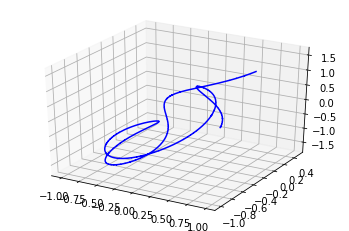

In [14]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(double_pendulum_array[:1000,0],double_pendulum_array[:1000,1],double_pendulum_array[:1000,2],color = "blue")

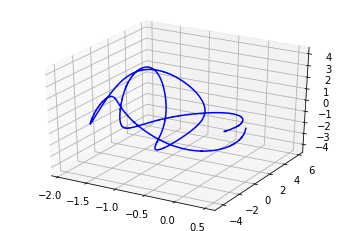

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(double_pendulum_array[:1000,3],double_pendulum_array[:1000,4],double_pendulum_array[:1000,5],color = "blue")

In [16]:
class GRU_reconstruction(torch.nn.Module):
    def __init__(self, hidden_size,input_size=1):
        super().__init__()
        self.RNN = torch.nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = 1)
        self.output_layer = torch.nn.Linear(hidden_size,3)

    def forward(self,x):
        output, _  = self.RNN(x)
        output = self.output_layer(output)
        return output
    
    def hidden_only(self,x):
        output, _  = self.RNN(x)
        return output

In [17]:
def compute_CCM_two_vars(X,Y,column_name1,column_name2):
  X_rows=X.shape[0]
  Y_rows=Y.shape[0]

  X=X.reshape((X_rows,1))
  Y=Y.reshape((Y_rows,1))

  print (X.shape,Y.shape)

  X_tensor = torch.stack(torch.Tensor(X[::10,:]).chunk(1000))
  Y_tensor = torch.stack(torch.Tensor(Y[::10,:]).chunk(1000))

  datasetX = torch.utils.data.TensorDataset(X_tensor)
  datasetY = torch.utils.data.TensorDataset(Y_tensor)

  dlX = torch.utils.data.DataLoader(datasetX, batch_size = 32, shuffle = False)
  dlY = torch.utils.data.DataLoader(datasetY, batch_size = 32, shuffle = False)

  dls = {"X":dlX, "Y":dlY}
  hiddens = {}
  for side in ["X","Y"]:
      loss_criterion = torch.nn.MSELoss()
      model = GRU_reconstruction(hidden_size = 20)
      optimizer = torch.optim.Adam(model.parameters(),lr = 0.01)
      for epoch in range(2):
          train_loss = 0
          for i,b in enumerate(dls[side]):
              optimizer.zero_grad()
              # print (type(b[0].shape))
              y_hat = model(b[0])
              loss1= loss_criterion(y_hat,b[0])
              loss = (loss1)  # + 0.5*loss2)
              loss.backward()
              optimizer.step()
              train_loss += loss.detach()
          train_loss /= (i+1)
          if (epoch%10)==0:
              print(f"Training_loss at epoch {epoch}: {train_loss}")

      hidden_path = []
      for i,b in enumerate(dls[side]):
          optimizer.zero_grad()
          y_hat = model.hidden_only(b[0])#[:,:,:]
          hidden_path.append(y_hat.detach())

      hiddens[side] = torch.cat(hidden_path).reshape(-1,y_hat.shape[-1])

  sc1, sc2 = causal_inf.CCM_compute(hiddens["X"].numpy()[::10],hiddens["Y"].numpy()[::10])
  plt.figure()
  label1=column_name1+'-->'+column_name2
  label2=column_name2+'-->'+column_name1
  plt.plot(sc1,label=label1)
  plt.plot(sc2,label = label2)
  plt.legend()
  plt.title("Cross Mapping from the Latent Process of Given Variables "+column_name1+"and "+column_name2)
  plt.show()

  return sc1,sc2

  


In [18]:
def get_index(column_name,list_of_columns=list(double_pendulum_data.columns)):
  return [i for i,x in enumerate(list_of_columns) if x==column_name][0]

variables=double_pendulum_data.columns
variables_pairs=[(x,y) for x,y in combinations(variables,2)]
variables_indices=[(get_index(x),get_index(y)) for x,y in variables_pairs]


print (variables_pairs)
print (variables_indices)

[('x1', 'y1'), ('x1', 'x2'), ('x1', 'y2'), ('x1', 'x1dot'), ('x1', 'y1dot'), ('x1', 'x2dot'), ('x1', 'y2dot'), ('y1', 'x2'), ('y1', 'y2'), ('y1', 'x1dot'), ('y1', 'y1dot'), ('y1', 'x2dot'), ('y1', 'y2dot'), ('x2', 'y2'), ('x2', 'x1dot'), ('x2', 'y1dot'), ('x2', 'x2dot'), ('x2', 'y2dot'), ('y2', 'x1dot'), ('y2', 'y1dot'), ('y2', 'x2dot'), ('y2', 'y2dot'), ('x1dot', 'y1dot'), ('x1dot', 'x2dot'), ('x1dot', 'y2dot'), ('y1dot', 'x2dot'), ('y1dot', 'y2dot'), ('x2dot', 'y2dot')]
[(0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (3, 4), (3, 5), (3, 6), (3, 7), (4, 5), (4, 6), (4, 7), (5, 6), (5, 7), (6, 7)]


(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.16772232949733734
Training_loss at epoch 0: 0.11478495597839355


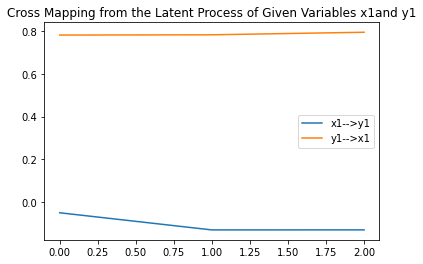

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.1524081975221634
Training_loss at epoch 0: 0.342247873544693


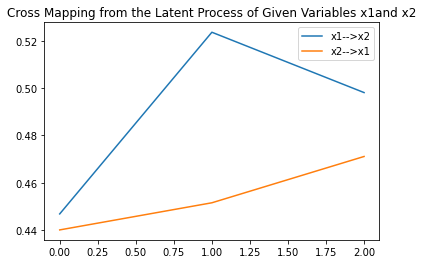

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.2117857187986374
Training_loss at epoch 0: 0.43765243887901306


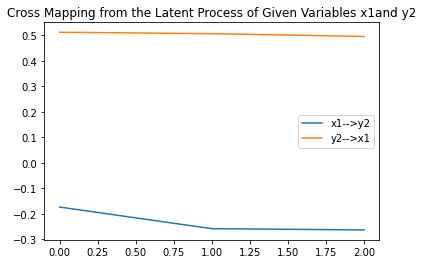

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.15417088568210602
Training_loss at epoch 0: 4.608541011810303


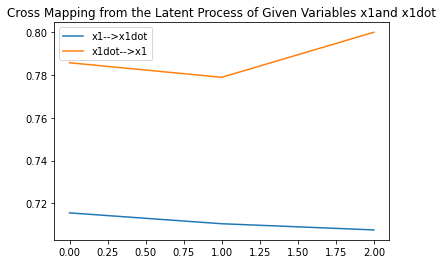

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.1272946447134018
Training_loss at epoch 0: 1.905495524406433


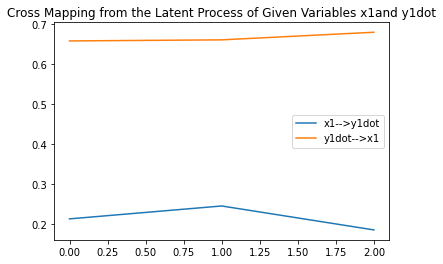

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.14104264974594116
Training_loss at epoch 0: 5.25346040725708


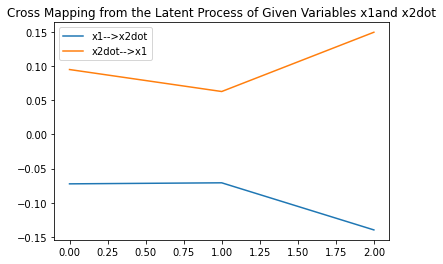

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.10680686682462692
Training_loss at epoch 0: 4.4702630043029785


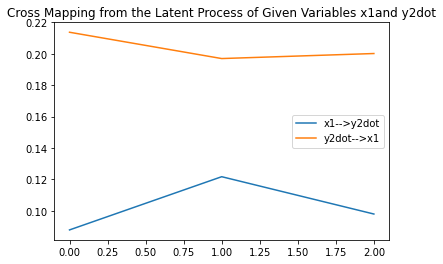

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.11366765946149826
Training_loss at epoch 0: 0.273997038602829


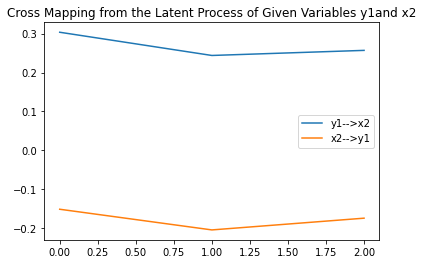

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.18362441658973694
Training_loss at epoch 0: 0.45321354269981384


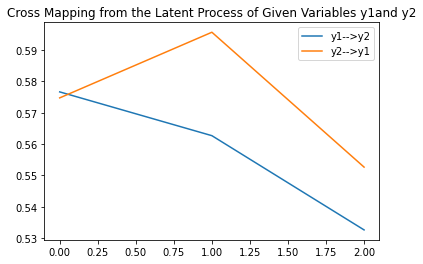

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.1397990733385086
Training_loss at epoch 0: 4.355806350708008


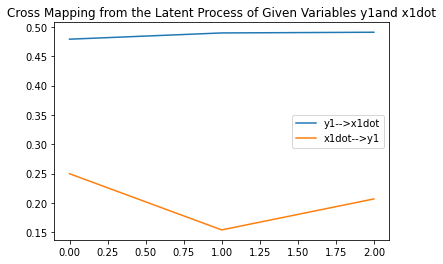

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.0837685838341713
Training_loss at epoch 0: 2.0782763957977295


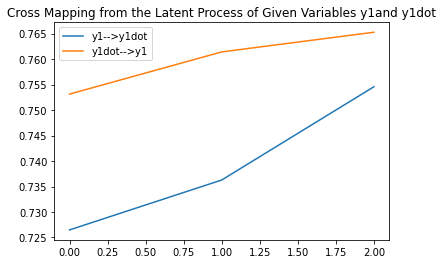

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.1531829833984375
Training_loss at epoch 0: 4.016096115112305


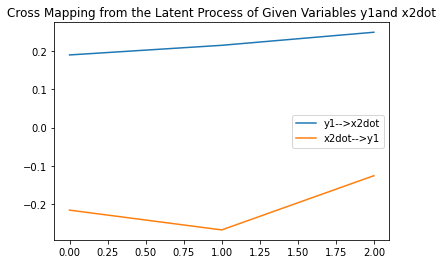

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.1034904271364212
Training_loss at epoch 0: 5.567800045013428


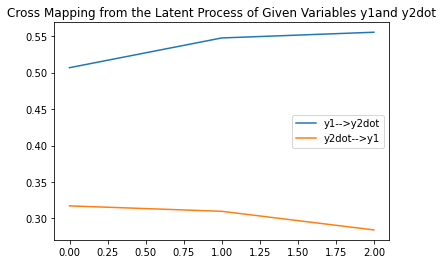

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.3401547968387604
Training_loss at epoch 0: 0.41048306226730347


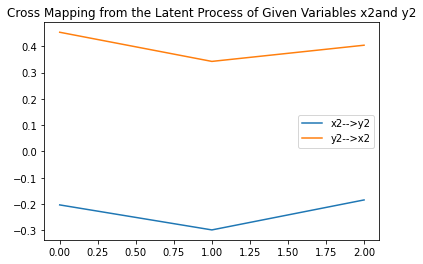

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.4092552065849304
Training_loss at epoch 0: 4.94462251663208


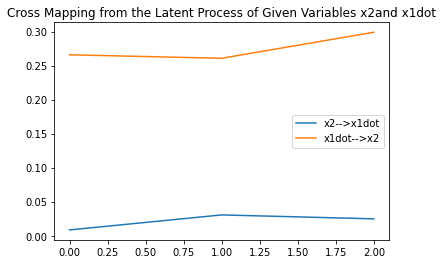

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.39365819096565247
Training_loss at epoch 0: 1.630578637123108


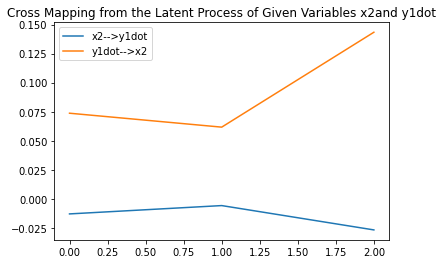

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.3265646994113922
Training_loss at epoch 0: 5.774430274963379


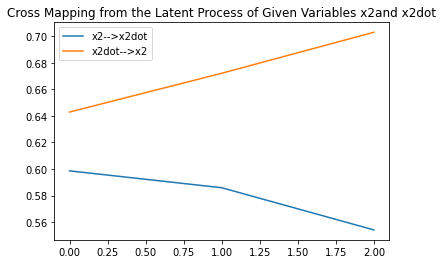

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.2841140627861023
Training_loss at epoch 0: 5.056654930114746


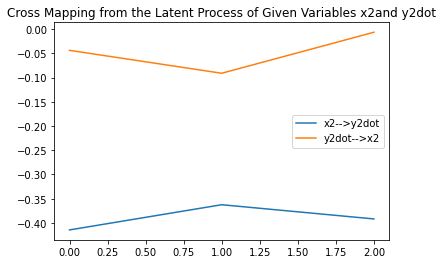

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.388962984085083
Training_loss at epoch 0: 5.112465858459473


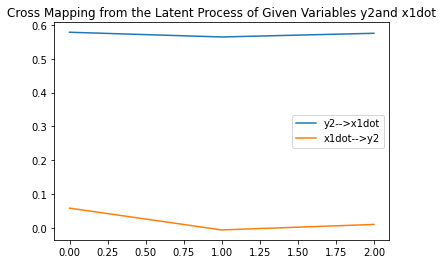

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.49710097908973694
Training_loss at epoch 0: 2.2641873359680176


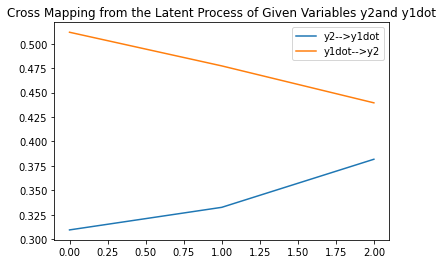

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.3804447054862976
Training_loss at epoch 0: 5.747731685638428


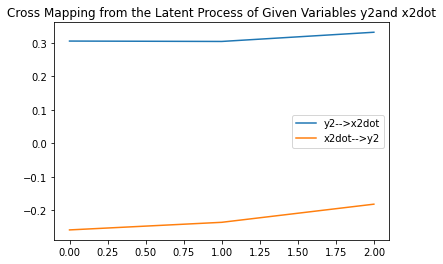

(17500, 1) (17500, 1)
Training_loss at epoch 0: 0.2811366617679596
Training_loss at epoch 0: 4.585525989532471


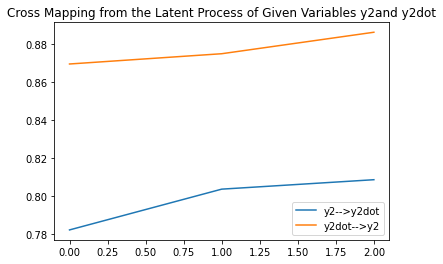

(17500, 1) (17500, 1)
Training_loss at epoch 0: 4.0377912521362305
Training_loss at epoch 0: 2.132990837097168


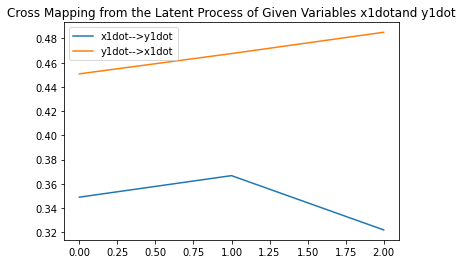

(17500, 1) (17500, 1)
Training_loss at epoch 0: 4.806103706359863
Training_loss at epoch 0: 4.656228065490723


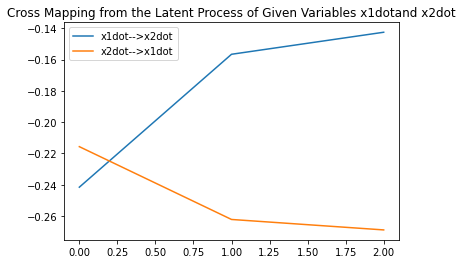

(17500, 1) (17500, 1)
Training_loss at epoch 0: 4.968204021453857
Training_loss at epoch 0: 4.460997104644775


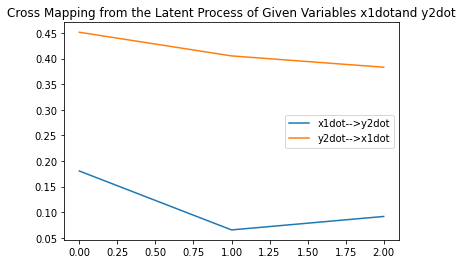

(17500, 1) (17500, 1)
Training_loss at epoch 0: 2.2105906009674072
Training_loss at epoch 0: 5.3710126876831055


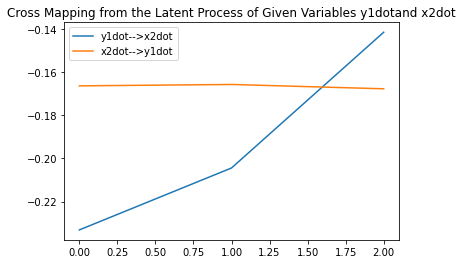

(17500, 1) (17500, 1)
Training_loss at epoch 0: 1.7214843034744263
Training_loss at epoch 0: 5.211913585662842


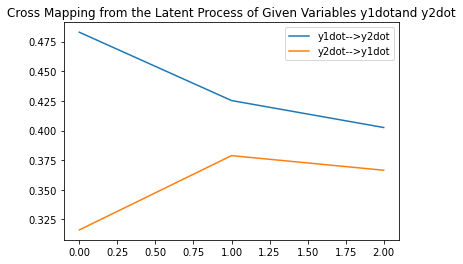

(17500, 1) (17500, 1)
Training_loss at epoch 0: 5.959805011749268
Training_loss at epoch 0: 4.4588704109191895


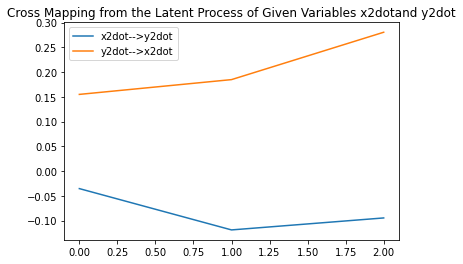

In [19]:
sc_dict={}
for l in range(len(variables_pairs)):
  var1=variables_pairs[l][0]
  var2=variables_pairs[l][1]
  index1=variables_indices[l][0]
  index2=variables_indices[l][1]
  this_sc1,this_sc2=compute_CCM_two_vars(double_pendulum_array[:17500,index1],double_pendulum_array[:17500,index2],var1,var2)
  sc_dict[(var1,var2)]=(this_sc1,this_sc2)